In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from mouse_record_dataloader import Mouse_records_dataset, Mouse_records_dataloader, Mouse_records_raw_dataloader, Mouse_records_raw_dataset

In [3]:
from torchvision import datasets
imagenet_root = "/mnt/lustre/datasets/ImageNet2012"
imagenet = datasets.ImageNet(imagenet_root, split='train')

In [4]:
dataset = Mouse_records_dataset(root='../train_xml')
dataset_raw = Mouse_records_raw_dataset(root='../train_xml')

In [5]:
dataset_raw.samples[0], imagenet.samples[0]

(('../train_xml/n01440764/n01440764_10027.xml', 0),
 ('/mnt/lustre/datasets/ImageNet2012/train/n01440764/n01440764_10026.JPEG', 0))

In [6]:
_, _, mouse_record, _ = dataset[0]
selected_record, et, mouse_record_raw, _ = dataset_raw[0]
mouse_record[:, 0], mouse_record_raw[:, 1], mouse_record[:, 0].shape, mouse_record_raw[:, 1].shape

(array([0.895    , 0.7687119, 0.654521 , 0.6347161, 0.6383877, 0.6458547,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ,
        0.65     , 0.65     , 0.65     , 0.65     , 0.65     , 0.65     ],
       dtype=float32),
 array([0.895, 0.865, 0.785, 0.705, 0.68 , 0.655, 0.64 , 0.635, 0.635,
        0.635, 0.635, 0.64 , 0.645, 0.65 ]),
 (30,),
 (14,))

In [7]:
not_selected_indices = np.load('data/not_selected.npy')
not_selected_indices

array([      0,       3,       9, ..., 1281133, 1281146, 1281147])

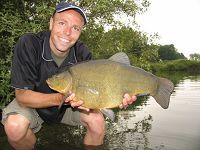

(None, (200, 150))

In [8]:
imagenet[1][0].show(), imagenet[1][0].size

In [9]:
def feature_to_pixels(x, y, width, height):
    return int(width * x), int(height * y)
def time_to_cmap(ts):
    return plt.cm.viridis((ts - ts.min()) / (ts.max() - ts.min()))

In [10]:
def plot_og_vs_interp(imagenet_idx, ab_idx, lim = True):
    im, lb = imagenet[imagenet_idx]
    plt.imshow(im)

    _, _, mouse_record,_ = dataset_raw[ab_idx]
    _, _, mouse_record_inter,_ = dataset[ab_idx]

    mouse_record_pixels = [feature_to_pixels(x,y, im.width, im.height) for _,x, y in mouse_record]
    cmap = time_to_cmap(np.asarray([ t-mouse_record[0,0] for t, _, _ in mouse_record]))

    x,y = zip(*mouse_record_pixels)
    plt.scatter(x, y, color = cmap, label="Recorded time series", s=200, edgecolors='black')
    plt.colorbar()
    mouse_record_pixels_interp = [feature_to_pixels(x,y, im.width, im.height) for x, y in mouse_record_inter][:7]
    cmap = time_to_cmap(np.asarray([100*i for i, _ in enumerate(mouse_record_inter[:7])]))
    plt.scatter(*zip(*mouse_record_pixels_interp), color=cmap, label="Interpolated time series", marker='*', s=200, edgecolors='black')

    if lim:
        plt.xlim(0, im.width)
        plt.ylim(im.height, 0)
    plt.legend()
    plt.show()

In [11]:
_,_,mr, _ = dataset_raw[4316]
mr[:, 1:], mr[:, 0]-mr[0,0]

(array([[0.57098765, 0.69135802],
        [0.95987654, 0.60493827],
        [0.58641975, 0.67078189],
        [0.56481481, 0.62139918]]),
 array([   0., 1120., 1164., 1399.]))

In [12]:
i = 8950

In [13]:
i+=1
imagenet.samples[i], i

(('/mnt/lustre/datasets/ImageNet2012/train/n01498041/n01498041_8529.JPEG', 6),
 8951)

In [12]:
mouse_record = np.load('data/mouse_record_interpolated.npy')

In [13]:
# Clean data aka reasonable estimated time
subset = np.logical_not(np.load("data/missing_file_names_mask.npy")) # Makes losses adapt to the selected mouse_records
losses = np.load("data/resnet50_losses_final_weights.npy")[subset]
mouse_records = np.load("data/mouse_record_interpolated.npy")
estimate_times=np.load('data/sample_estimate_times.npy')
clean_subset = estimate_times[subset] < 3000
clean_subset = np.logical_and(clean_subset, estimate_times[subset] > 0)
clean_id_to_dataset_id = np.arange(len(dataset))[clean_subset]
assert np.allclose(mouse_records[clean_subset][8900], mouse_records[clean_id_to_dataset_id[8900]])

In [14]:
clean_id = 8900
dataset_id = clean_id_to_dataset_id[clean_id]
imagenet.samples[clean_id], dataset.samples[dataset_id], dataset_id

(('/mnt/lustre/datasets/ImageNet2012/train/n01498041/n01498041_7978.JPEG', 6),
 ('../train_xml/n01514668/n01514668_2963.xml', 7),
 10045)

In [15]:
def find_imagenet_idx(clean_id):
    dataset_id = clean_id_to_dataset_id[clean_id]
    target_path = dataset.samples[dataset_id][0].split('/')[-1].split('.')[0]
    for i in range(len(imagenet.samples)-dataset_id):
        if target_path in imagenet.samples[i][0]:
            return i


In [16]:
_,et,mr,_ = dataset_raw[dataset_id]
mr[:, 0]-mr[0,0], mr[:, 1:], et

(array([   0., 5937., 5958., 5993., 6087., 6157., 6206.]),
 array([[0.25925926, 0.1043956 ],
        [0.64814815, 0.95604396],
        [0.62654321, 0.9010989 ],
        [0.60802469, 0.84615385],
        [0.60802469, 0.82967033],
        [0.60802469, 0.66483516],
        [0.60493827, 0.52747253]]),
 1187.0)

In [20]:
rec = mr[:, 0]-mr[0,0]
(rec<et).sum()

1

In [21]:
mr[:, 1:], mr[:, 0]-mr[0,0], et

(array([[0.25925926, 0.1043956 ],
        [0.64814815, 0.95604396],
        [0.62654321, 0.9010989 ],
        [0.60802469, 0.84615385],
        [0.60802469, 0.82967033],
        [0.60802469, 0.66483516],
        [0.60493827, 0.52747253]]),
 array([   0., 5937., 5958., 5993., 6087., 6157., 6206.]),
 1187.0)

In [28]:
t0 = mr[0,0]
mr[:,0] = mr[:,0] - t0

In [18]:
_,_, mr, _= dataset_raw[dataset_id]
mr[:, 0]=mr[:, 0]-mr[0,0]
mr

array([[0.00000000e+00, 9.19753086e-01, 7.87037037e-01],
       [3.30000000e+01, 8.14814815e-01, 7.26851852e-01],
       [6.90000000e+01, 7.56172840e-01, 6.89814815e-01],
       [9.90000000e+01, 6.94444444e-01, 6.62037037e-01],
       [1.27000000e+02, 6.66666667e-01, 6.29629630e-01],
       [1.59000000e+02, 6.48148148e-01, 6.01851852e-01],
       [1.90000000e+02, 6.01851852e-01, 5.55555556e-01],
       [2.20000000e+02, 5.74074074e-01, 5.41666667e-01],
       [3.42000000e+02, 5.64814815e-01, 5.32407407e-01],
       [3.77000000e+02, 5.43209877e-01, 5.00000000e-01],
       [9.62000000e+02, 5.37037037e-01, 4.95370370e-01]])

In [30]:
min(mr[-1,0], et), mr[-1,0]


10

In [21]:
_,et, mr, _ = dataset[dataset_id]

et, mr

(1104.0,
 array([[ 0.9197531 ,  0.787037  ],
        [ 0.69280374,  0.66090727],
        [ 0.58961254,  0.54708487],
        [ 0.5684865 ,  0.5457151 ],
        [ 0.5197715 ,  0.4686813 ],
        [ 0.35999963,  0.27120283],
        [ 0.16887647,  0.04540661],
        [ 0.        , -0.        ],
        [ 0.        , -0.        ],
        [ 0.25143138,  0.15829448],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.       

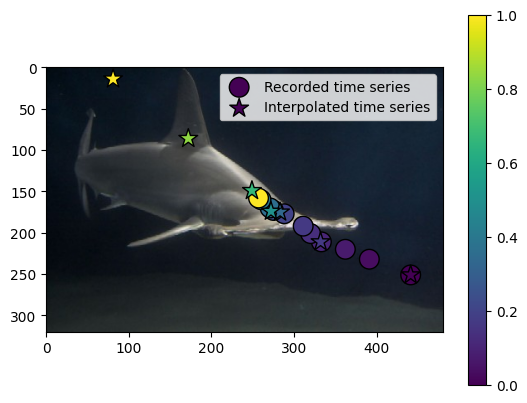

In [17]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

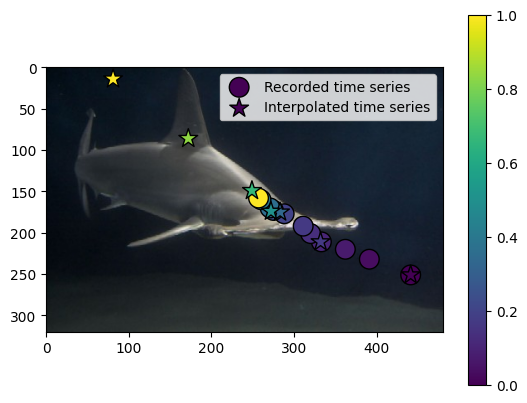

In [21]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

xml_file: ../train_xml/n01494475/n01494475_169.xml


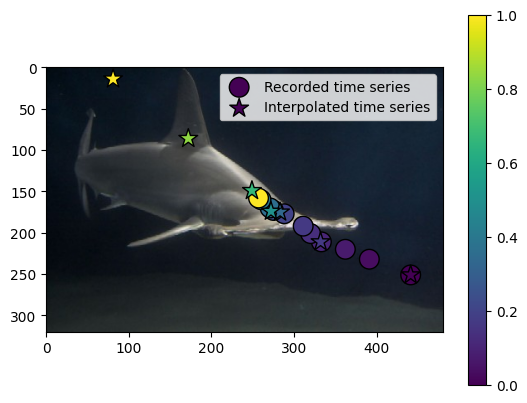

In [25]:
i = 4906
imagenet_id = find_imagenet_idx(i)
dataset_id = clean_id_to_dataset_id[i]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

xml_file: ../train_xml/n01514668/n01514668_2963.xml


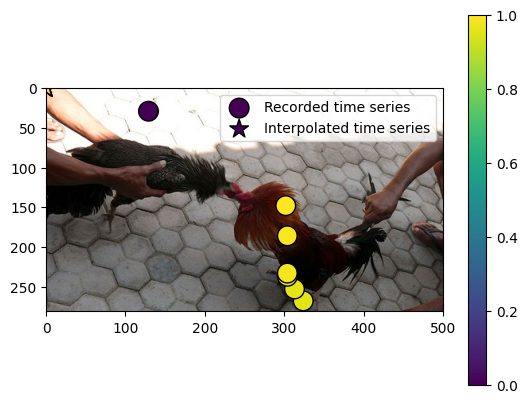

In [23]:
imagenet_id = find_imagenet_idx(8900)
dataset_id = clean_id_to_dataset_id[8900]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

xml_file: ../train_xml/n01514668/n01514668_2963.xml


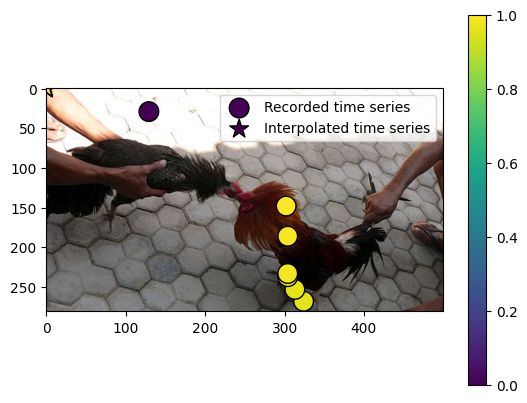

In [24]:
plot_og_vs_interp(imagenet_id, dataset_id, lim=False)

In [50]:
_,_,mr,_=dataset[dataset_id]
mask_away = np.logical_not(np.any(mr > 1, axis=1)|np.any(mr < 0, axis=1))[:, None]
mask_away * mr
# mr * np.array(mr>1)

array([[0.97530866, 0.73251027],
       [0.7361643 , 0.6805362 ],
       [0.82422704, 0.71137404],
       [0.8783896 , 0.8896094 ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ]], dtype=flo

xml_file: ../train_xml/n01514859/n01514859_3059.xml


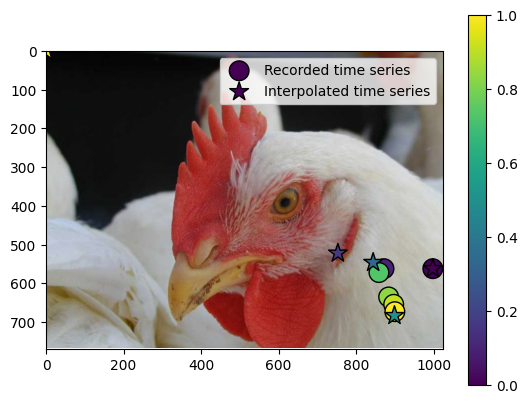

In [29]:
imagenet_id = find_imagenet_idx(9746)
dataset_id = clean_id_to_dataset_id[9746]
plot_og_vs_interp(imagenet_id, dataset_id, lim=True)

xml_file: ../train_xml/n01491361/n01491361_3313.xml


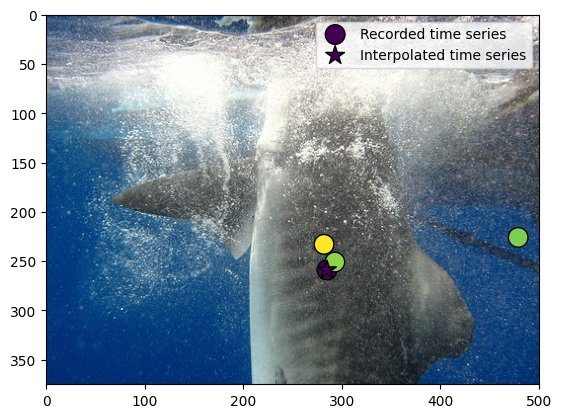

In [56]:
plot_og_vs_interp(4345, 4316)

xml_file: ../train_xml/n01440764/n01440764_10027.xml


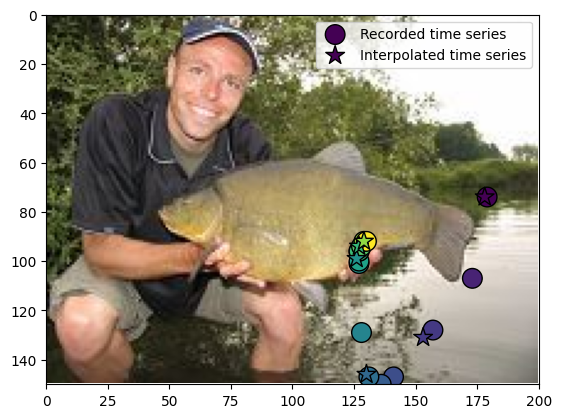

In [15]:
plot_og_vs_interp(1,0)

xml_file: ../train_xml/n01440764/n01440764_10029.xml


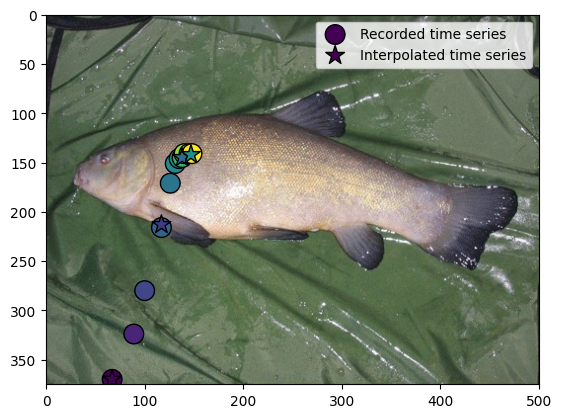

In [16]:
plot_og_vs_interp(2,1)

xml_file: ../train_xml/n01440764/n01440764_10040.xml


ValueError: zero-size array to reduction operation minimum which has no identity

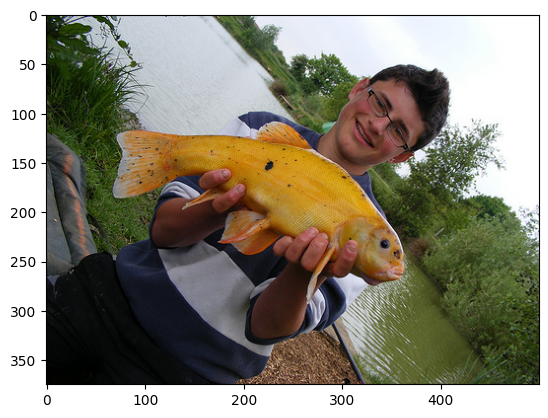

In [17]:
plot_og_vs_interp(3,2)

xml_file: ../train_xml/n01440764/n01440764_10042.xml


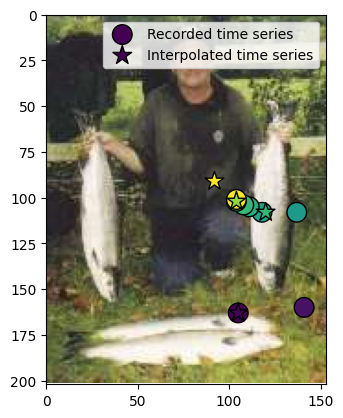

In [18]:
plot_og_vs_interp(4,3)